In [3]:
%pylab inline
import ROOT, rat
import os, sys, pickle
import jp_mpl as jplot

Populating the interactive namespace from numpy and matplotlib


### Read all the PMT information from all the available files

In [6]:
# List the files
indir = '/home/jp/projects/snoplus/laserball_calibration/all_runs'
file_list = os.listdir(indir)
outdir = '/home/jp/projects/snoplus/laserball_calibration/all_runs_pckl'

### Making manageable files from ROOT files

In [8]:
for file_index, file_name in enumerate(file_list):

    print 'Doing file', file_name ,
    outfile_path = os.path.join(outdir, file_name.rstrip('.root')+'.pckl')
    if os.path.isfile(outfile_path):
        print ' ... exists. Skipping it.'
        continue
    
    qhs       = np.zeros(pmt_radius.size)
    qhl       = np.zeros_like(qhs)
    occupancy = np.zeros_like(qhl)
    not_valid = 0
    reader = rat.socreader(os.path.join(indir, file_name))

    for soc, run in reader:
        # Get the run information
        result  = soc.GetFitResult(soc.GetFitNames()[0])
        vertex  = np.array(result.GetVertex(0).GetPosition())
        calib   = np.array(soc.GetCalib().GetPos())
        npulses = soc.GetNPulsesTriggered()

        # Go over the PMTs of interest
        # Should add some quality criteria here for PMTs
        for one_id in range(pmt_radius.size):
            try:
                pmt = soc.GetSOCPMT(one_id)
            except:
                not_valid +=1
                continue
            qhs[one_id] = np.sum(np.array(pmt.GetQHSs()))
            qhl[one_id] = np.sum(np.array(pmt.GetQHLs()))
            occupancy[one_id] = pmt.GetPromptOccupancy()
            
      
    reader.close()
    print '... done! - not valid PMTs ', not_valid
    
    # Save the file
    ofile = open(outfile_path, 'w')
    pickle.dump({'vertex':vertex, 'calib':calib, 'npulses':npulses,
                 'qhs':qhs, 'qhl':qhl, 'occupancy':occupancy}, ofile)
    ofile.close()

Doing file SOC_0000017377_reprocessed.root  ... exists. Skipping it.
Doing file SOC_0000017375_reprocessed.root  ... exists. Skipping it.
Doing file SOC_0000017378_reprocessed.root  ... exists. Skipping it.
Doing file SOC_0000100558.root  ... exists. Skipping it.
Doing file SOC_0000100559.root  ... exists. Skipping it.
Doing file SOC_0000100560.root  ... exists. Skipping it.
Doing file SOC_0000100554.root  ... exists. Skipping it.
Doing file SOC_0000017386_reprocessed.root  ... exists. Skipping it.
Doing file SOC_0000100556.root  ... exists. Skipping it.
Doing file SOC_0000017376_reprocessed.root  ... exists. Skipping it.
Doing file SOC_0000100555.root  ... exists. Skipping it.
Doing file SOC_0000017384_reprocessed.root  ... exists. Skipping it.


### Load the python-friendly files

In [176]:
# Load all the already available files
pfile_list = os.listdir(outdir)
data = []
for one_file in pfile_list:
    print 'Loading ', one_file
    infile = open(os.path.join(outdir, one_file))
    data.append(pickle.load(infile))
    data[-1]['run'] = int(one_file[4:14])
    infile.close()

Loading  SOC_0000100559.pckl
Loading  SOC_0000100560.pckl
Loading  SOC_0000100558.pckl
Loading  SOC_0000017386_reprocessed.pckl
Loading  SOC_0000017375_reprocessed.pckl
Loading  SOC_0000017376_reprocessed.pckl
Loading  SOC_0000017377_reprocessed.pckl
Loading  SOC_0000100554.pckl
Loading  SOC_0000100555.pckl
Loading  SOC_0000100556.pckl
Loading  SOC_0000017384_reprocessed.pckl
Loading  SOC_0000017378_reprocessed.pckl


### Load the PMT information

In [4]:
pmt_info = pickle.load(open('/home/jp/projects/snoplus/python_modules/pmt_positions.pckl'))

### Select which PMTs will be used

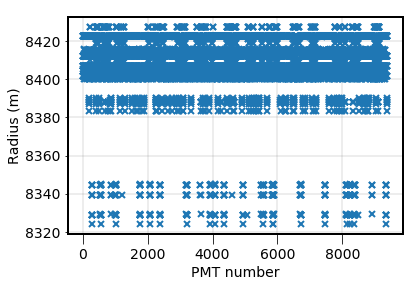

In [179]:
valid_pmts = (pmt_info['type'] == 1)
pmt_radius = np.sqrt(np.sum(pmt_info['xyz']**2, axis=1))
plt.plot(pmt_radius[valid_pmts], 'x')
plt.xlabel('PMT number')
plt.ylabel('Radius (m)')

### For each laserball run, calculate emission angle and distance to every PMT

In [189]:
pos_key = 'vertex'
for one_run in data:
    one_run['distance'] = np.sqrt(np.sum((pmt_info['xyz'] - one_run[pos_key])**2,axis=1))
    one_run['costheta'] = (pmt_info['xyz'][:,2] - one_run[pos_key][2])/one_run['distance']
    one_run['phi'] = np.arctan2((pmt_info['xyz'][:,1] - one_run[pos_key][1]), 
                                (pmt_info['xyz'][:,0] - one_run[pos_key][0]))

In [181]:
for i, one_run in enumerate(data):
    print i, one_run[pos_key]

0 [   2.24983931 -203.58409119   25.98548508]
1 [   3.88579869 -207.37480164   27.52195358]
2 [   6.7621541  -208.42858887   26.4679184 ]
3 [   -9.96615696  -322.74142456  4855.18701172]
4 [   0.24428572 -226.06359863   23.39888954]
5 [   6.92900801 -225.00495911   24.29921532]
6 [   2.34015226 -226.16465759   24.06827164]
7 [   1.49445307 -205.81411743   27.46838951]
8 [   5.36462784 -206.92816162   25.05916977]
9 [   3.82698131 -207.07707214   24.78620338]
10 [  -1.41507101 -219.31124878   21.13463783]
11 [   8.0424242  -222.29763794    7.75781345]


In [219]:
# Analyze within a single run
cosaxis = np.linspace(-1, 1, 11)
phiaxis = np.linspace(-np.pi, np.pi, 7)
thisrun = (one_run['qhs']>0.)*(one_run['qhs']<20000)
n, x, y = np.histogram2d(one_run['phi'][valid_pmts*thisrun], one_run['costheta'][valid_pmts*thisrun], 
                         [phiaxis, cosaxis],
                         weights = one_run['qhs'][valid_pmts*thisrun])

(array([  6.01000000e+02,   5.60000000e+01,   9.90000000e+01,
          2.43000000e+02,   5.17000000e+02,   8.11000000e+02,
          1.16300000e+03,   1.16000000e+03,   1.00800000e+03,
          8.12000000e+02,   5.95000000e+02,   3.94000000e+02,
          2.84000000e+02,   2.25000000e+02,   1.64000000e+02,
          1.64000000e+02,   1.53000000e+02,   1.31000000e+02,
          1.22000000e+02,   7.80000000e+01,   5.80000000e+01,
          4.90000000e+01,   3.90000000e+01,   3.60000000e+01,
          3.70000000e+01,   2.60000000e+01,   2.30000000e+01,
          2.00000000e+01,   1.80000000e+01,   1.20000000e+01,
          1.40000000e+01,   1.00000000e+01,   7.00000000e+00,
          7.00000000e+00,   1.10000000e+01,   7.00000000e+00,
          1.30000000e+01,   6.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   6.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   7.00000000e+00,   9.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   4.00000000e+00,
        

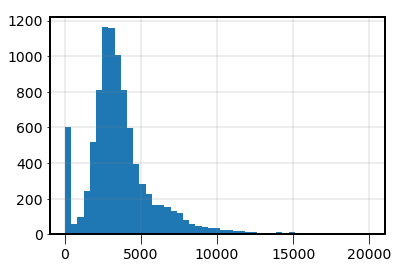

In [220]:
plt.hist(one_run['qhs'], np.linspace(0, 20000))

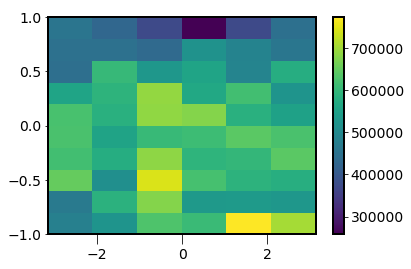

In [221]:
plt.pcolor(phiaxis, cosaxis, n.T)
plt.colorbar()

In [183]:
one_run = data[1]
print 'Distance std', one_run['distance'][valid_pmts].std()
print 'Vtx displacement', np.sqrt(np.sum(one_run[pos_key]**2))
costheta_ref = [-1., -0.9]

Distance std 122.53953923
Vtx displacement 209.229218117


PMTs in reference region  482
Distance - mu: 8433.80560709 , sigma: 46.6487244961


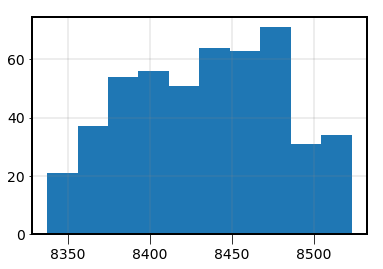

In [184]:
pmt_ref =(one_run['costheta']>costheta_ref[0])*(one_run['costheta']<costheta_ref[1])
print 'PMTs in reference region ', np.sum(pmt_ref[valid_pmts])
plt.figure()
pmt_distance = one_run['distance'][valid_pmts*pmt_ref]
print 'Distance - mu:', pmt_distance.mean(), ', sigma:', pmt_distance.std()
dummy = plt.hist(pmt_distance)

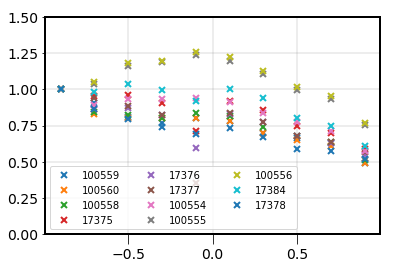

In [187]:
nbins = 10
cos_bins = np.linspace(-1, 1, nbins+1)
cos_centers = (cos_bins[1:] + cos_bins[:-1])/2.
plt.figure()


for irun, one_run in enumerate(data):
    if irun ==  3:
        continue

    qhs = np.zeros(nbins)
    qhl = np.zeros_like(qhs)
    occ = np.zeros_like(qhs)

    for ibin in range(nbins):
        ipmts = (one_run['costheta']>cos_bins[ibin])*(one_run['costheta']<cos_bins[ibin+1])
        pmt_distance = one_run['distance'][valid_pmts*ipmts]


        if ibin == 0:
            rqhs = one_run['qhs'][valid_pmts*ipmts].mean()
            rqhl = one_run['qhl'][valid_pmts*ipmts].mean()
            rocc = one_run['occupancy'][valid_pmts*ipmts].mean()

        qhs[ibin] = one_run['qhs'][valid_pmts*ipmts].mean()/rqhs
        qhl[ibin] = one_run['qhl'][valid_pmts*ipmts].mean()/rqhl
        occ[ibin] = one_run['occupancy'][valid_pmts*ipmts].mean()/rocc    

        #print 'Range', cos_bins[ibin], cos_bins[ibin+1], \
        #    ', mu:', pmt_distance.mean(), \
        #    ', sigma:', pmt_distance.std()

    #print rqhs, rqhl, rocc
    plt.plot(cos_centers, qhs, 'x', label = one_run['run'])
    plt.ylim(0., 1.5)
plt.legend(loc=0,ncol=3)

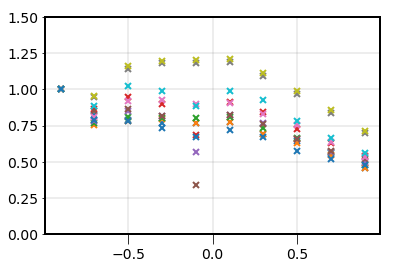

In [186]:
nbins = 10
cos_bins = np.linspace(-1, 1, nbins+1)
cos_centers = (cos_bins[1:] + cos_bins[:-1])/2.
plt.figure()


for irun, one_run in enumerate(data):
    if irun ==  3:
        continue

    qhs = np.zeros(nbins)
    qhl = np.zeros_like(qhs)
    occ = np.zeros_like(qhs)

    for ibin in range(nbins):
        ipmts = (one_run['costheta']>cos_bins[ibin])*(one_run['costheta']<cos_bins[ibin+1])
        pmt_distance = one_run['distance'][valid_pmts*ipmts]


        if ibin == 0:
            rqhs = one_run['qhs'][valid_pmts*ipmts].sum()
            rqhl = one_run['qhl'][valid_pmts*ipmts].sum()
            rocc = one_run['occupancy'][valid_pmts*ipmts].sum()

        qhs[ibin] = one_run['qhs'][valid_pmts*ipmts].sum()/rqhs
        qhl[ibin] = one_run['qhl'][valid_pmts*ipmts].sum()/rqhl
        occ[ibin] = one_run['occupancy'][valid_pmts*ipmts].sum()/rocc    

        #print 'Range', cos_bins[ibin], cos_bins[ibin+1], \
        #    ', mu:', pmt_distance.mean(), \
        #    ', sigma:', pmt_distance.std()

    #print rqhs, rqhl, rocc
    plt.plot(cos_centers, qhs, 'x')
    plt.ylim(0., 1.5)

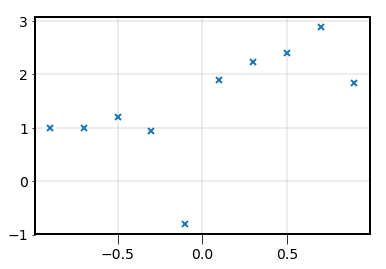

In [167]:
nbins = 10
cos_bins = np.linspace(-1, 1, nbins+1)
cos_centers = (cos_bins[1:] + cos_bins[:-1])/2.
plt.figure()


for irun, one_run in enumerate(data):
    if irun !=  3:
        continue

    qhs = np.zeros(nbins)
    qhl = np.zeros_like(qhs)
    occ = np.zeros_like(qhs)

    for ibin in range(nbins):
        ipmts = (one_run['costheta']>cos_bins[ibin])*(one_run['costheta']<cos_bins[ibin+1])
        pmt_distance = one_run['distance'][valid_pmts*ipmts]


        if ibin == 0:
            rqhs = one_run['qhs'][valid_pmts*ipmts].mean()
            rqhl = one_run['qhl'][valid_pmts*ipmts].mean()
            rocc = one_run['occupancy'][valid_pmts*ipmts].mean()

        qhs[ibin] = one_run['qhs'][valid_pmts*ipmts].mean()/rqhs
        qhl[ibin] = one_run['qhl'][valid_pmts*ipmts].mean()/rqhl
        occ[ibin] = one_run['occupancy'][valid_pmts*ipmts].mean()/rocc    

        #print 'Range', cos_bins[ibin], cos_bins[ibin+1], \
        #    ', mu:', pmt_distance.mean(), \
        #    ', sigma:', pmt_distance.std()

    #print rqhs, rqhl, rocc
    plt.plot(cos_centers, qhs, 'x')
    #plt.ylim(0., 1.5)